In [1]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import yaml
from classy import Class
#from iminuit import minimize as minuit

In [2]:
font = {'size': 14}
axislabelfontsize='large'
matplotlib.rc('font', **font)

In [3]:
from correlator import Correlator
from io_pb import ReadWrite
from likelihood import Likelihood

# Data format for EFT likelihood

The best way to understand what is the format of the data read by the EFT likelihood is to construct one. 

***Let us construct a fake data from an EFT prediction.***

In [4]:
datadir = os.path.join(os.path.expanduser('~'), 'Desktop', 'Projects', 'Code_GH', 'pybird', 'data')

In [5]:
datadir

'/Users/marcomarinucci/Desktop/Projects/Code_GH/pybird/data'

### Setting the EFT prediction

Redshift?

In [6]:
z = np.array([0.9,1.2,1.5,1.8])

First, we create a CLASS engine `M`, that will provide linear cosmology stuff to the PyBird correlator engine. 

In [7]:
M = Class()
h = 0.675
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': h, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}

M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 1, 'z_max_pk': 10})
M.compute()

In [8]:
from scipy.interpolate import interp1d
kk = np.logspace(-5, 0, 200)
#pk_lin = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) 

pk_lin1 = np.array([M.pk_lin(k*M.h(), z[0])*M.h()**3 for k in kk]) 
pk_lin2 = np.array([M.pk_lin(k*M.h(), z[1])*M.h()**3 for k in kk]) 
pk_lin3 = np.array([M.pk_lin(k*M.h(), z[2])*M.h()**3 for k in kk]) 
pk_lin4 = np.array([M.pk_lin(k*M.h(), z[3])*M.h()**3 for k in kk]) 
ipk_lin1 = interp1d(kk, pk_lin1, kind='cubic')
ipk_lin2 = interp1d(kk, pk_lin2, kind='cubic')
ipk_lin3 = interp1d(kk, pk_lin3, kind='cubic')
ipk_lin4 = interp1d(kk, pk_lin4, kind='cubic')

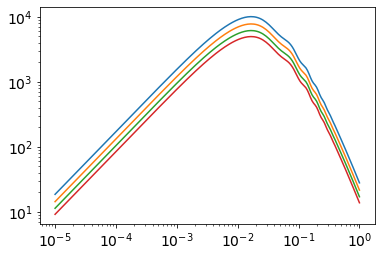

In [9]:
plt.plot(kk, pk_lin1)
plt.plot(kk, pk_lin2)
plt.plot(kk, pk_lin3)
plt.plot(kk, pk_lin4)

plt.xscale('log')
plt.yscale('log')

In [10]:
D1, f1 = M.scale_independent_growth_factor(z[0]), M.scale_independent_growth_factor_f(z[0])
D2, f2 = M.scale_independent_growth_factor(z[1]), M.scale_independent_growth_factor_f(z[1])
D3, f3 = M.scale_independent_growth_factor(z[2]), M.scale_independent_growth_factor_f(z[2])
D4, f4 = M.scale_independent_growth_factor(z[3]), M.scale_independent_growth_factor_f(z[3])

We need some distortion (AP) parameters.

In [11]:
H_ap1, D_ap1 = M.Hubble(z[0]) / M.Hubble(0.), M.angular_distance(z[0]) * M.Hubble(0.)
H_ap2, D_ap2 = M.Hubble(z[1]) / M.Hubble(0.), M.angular_distance(z[1]) * M.Hubble(0.)
H_ap3, D_ap3 = M.Hubble(z[2]) / M.Hubble(0.), M.angular_distance(z[2]) * M.Hubble(0.)
H_ap4, D_ap4 = M.Hubble(z[3]) / M.Hubble(0.), M.angular_distance(z[3]) * M.Hubble(0.)

In [12]:
M_fid = Class()
cosmo_ap = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.6776, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M_fid.set(cosmo_ap)
M_fid.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': 10})
M_fid.compute()

Omega_m_fid = M_fid.Omega_m()
H_fid1, D_fid1 = M_fid.Hubble(z[0]) / M_fid.Hubble(0.), M_fid.angular_distance(z[0]) * M_fid.Hubble(0.)
H_fid2, D_fid2 = M_fid.Hubble(z[1]) / M_fid.Hubble(0.), M_fid.angular_distance(z[1]) * M_fid.Hubble(0.)
H_fid3, D_fid3 = M_fid.Hubble(z[2]) / M_fid.Hubble(0.), M_fid.angular_distance(z[2]) * M_fid.Hubble(0.)
H_fid4, D_fid4 = M_fid.Hubble(z[3]) / M_fid.Hubble(0.), M_fid.angular_distance(z[3]) * M_fid.Hubble(0.)

print ('Omega_m_fid: %.3f' % Omega_m_fid)
print ('Omega_m: %.4f' % M.Omega_m())

Omega_m_fid: 0.310
Omega_m: 0.3124


Next, we create a PyBird Correlator engine `N`.

In [13]:
dk = 0.01
kd = np.arange(0.005, 0.5, dk)

In [56]:
b2z(0.9)

-0.37429529500000003

In [73]:
#Euclid specifics
V = np.array([7.15, 9.25, 10.51, 11.25])*1e9 # in (Mpc/h)^3
ng = np.array([1.55, 0.7, 0.27, 0.12])*1e-3 # in (h/Mpc)^3
#we use the specifics delined in 1907.06666
def b1z(zz):
    b10 = 0.9
    return b10 + 0.4*zz
def b2z(zz):
    return (-0.704 - 0.208*zz + 0.183*zz**2 - 0.00771*zz**3 )
def bG2z(zz):
    return -(2/7)*(b1z(zz)-1)

def c0(zz):
    return 5 * M.scale_independent_growth_factor(zz)**2
def c2(zz):
    return 5 * M.scale_independent_growth_factor(zz)**2
def c4(zz):
    return M.scale_independent_growth_factor(zz)**2

def bG3z(zz):
    return  (23/42)*(1-b1z(zz))

def b2true(zz):
    return 1/2*(2*b1z(zz) + 7*bG2z(zz))
    #return 1.
def b4true(zz):
    return b2z(zz) - 7*bG2z(zz)
    #return 0.
def b3true(zz):
    agamma = 10/7
    agammaa = 2/3
    g = 3/7
    return 21/2* ((g - agammaa/2)*b1z(zz) + agamma *bG2z(zz) - bG3z(zz))
    #return 0.
def cct_true(zz):
    f = M.scale_independent_growth_factor_f(zz)
    kM = 0.7
    return -((2695*b1z(zz)**4*f**2*kM**2*c0(zz) + 6909*b1z(zz)**3*f**3*kM**2*c0(zz) + 6790*b1z(zz)**2*f**4*kM**2*c0(zz) + 3045*b1z(zz)*f**5*kM**2*c0(zz) + 525*f**6*kM**2*c0(zz) - 2695*b1z(zz)**4*f**2*kM**2*c2(zz) - 8295*b1z(zz)**3*f**3*kM**2*c2(zz) - 9275*b1z(zz)**2*f**4*kM**2*c2(zz) - \
            4425*b1z(zz)*f**5*kM**2*c2(zz) - 750*f**6*kM**2*c2(zz) + 1386*b1z(zz)**3*f**3*kM**2*c4(zz) + 2485*b1z(zz)**2*f**4*kM**2*c4(zz) + 1380*b1z(zz)*f**5*kM**2*c4(zz) + 225*f**6*kM**2*c4(zz))/(70*(231*b1z(zz)**3 + 315*b1z(zz)**2*f + 105*b1z(zz)*f**2 + 5*f**3)))
def cr1_true(zz):
    f = M.scale_independent_growth_factor_f(zz)
    kM = 0.7
    return -((kM**2*(-385*b1z(zz)**3*f**3*c0(zz) - 987*b1z(zz)**2*f**4*c0(zz) - 795*b1z(zz)*f**5*c0(zz) - 225*f**6*c0(zz) + 1155*b1z(zz)**4*f**2*c2(zz) + \
               3940*b1z(zz)**3*f**3*c2(zz) + 4710*b1z(zz)**2*f**4*c2(zz) + 2300*b1z(zz)*f**5*c2(zz) + 375*f**6*c2(zz) - 1980*b1z(zz)**3*f**3*c4(zz) - \
               3198*b1z(zz)**2*f**4*c4(zz) - 1480*b1z(zz)*f**5*c4(zz) - 150*f**6*c4(zz)))/(10*(231*b1z(zz)**3 + 315*b1z(zz)**2*f + 105*b1z(zz)*f**2 + 5*f**3)))
def cr2_true(zz):
    f = M.scale_independent_growth_factor_f(zz)
    kM = 0.7
    return -((kM**2*(385*b1z(zz)**2*f**4*c0(zz) + 462*b1z(zz)*f**5*c0(zz) + 165*f**6*c0(zz) - 1155*b1z(zz)**3*f**3*c2(zz) - 2365*b1z(zz)**2*f**4*c2(zz) \
                    - 1485*b1z(zz)*f**5*c2(zz) - 275*f**6*c2(zz) + 2310*b1z(zz)**3*f**3*c4(zz) + 3555*b1z(zz)**2*f**4*c4(zz) + 1548*b1z(zz)*f**5*c4(zz) \
                    + 135*f**6*c4(zz)))/(10*(231*b1z(zz)**3 + 315*b1z(zz)**2*f + 105*b1z(zz)*f**2 + 5*f**3)))

In [74]:
f1

0.8584349531083387

In [75]:
c0(0.9)

2.017924199838324

In [76]:
eft_params1, eft_params2, eft_params3, eft_params4

({'b1': 1.26,
  'b2': 1.0,
  'b3': 1.6407142857142858,
  'b4': -0.22859059000000004,
  'cct': 0.32784663498999933,
  'cr1': -5.257594434418926,
  'cr2': 1.7618985412538868,
  'ce0': 1.0,
  'ce1': 0.0,
  'ce2': 0.0},
 {'b1': 1.38,
  'b2': 1.0,
  'b3': 1.9364285714285712,
  'b4': 0.05659711999999972,
  'cct': 0.2913496402842992,
  'cr1': -4.785415317862085,
  'cr2': 1.5681687245236786,
  'ce0': 1.0,
  'ce1': 0.0,
  'ce2': 0.0},
 {'b1': 1.5,
  'b2': 1.0,
  'b3': 2.232142857142857,
  'b4': 0.36972875000000005,
  'cct': 0.25012276499994895,
  'cr1': -4.2374972668369315,
  'cr2': 1.3487912548071799,
  'ce0': 1.0,
  'ce1': 0.0,
  'ce2': 0.0},
 {'b1': 1.62,
  'b2': 1.0,
  'b3': 2.5278571428571435,
  'b4': 0.7095552800000002,
  'cct': 0.2122108030741336,
  'cr1': -3.72057502411621,
  'cr2': 1.1465590812398134,
  'ce0': 1.0,
  'ce1': 0.0,
  'ce2': 0.0})

In [77]:
eft_params1 = {'b1': b1z(z[0]), 'b2': b2true(z[0]),  'b3': b3true(z[0]),  'b4': b4true(z[0]),
              'cct': cct_true(z[0]), 'cr1': cr1_true(z[0]), 'cr2': cr2_true(z[0]),
              'ce0': 1., 'ce1': 0., 'ce2': 0.
              }
eft_params2 = {'b1': b1z(z[1]), 'b2': b2true(z[1]),  'b3': b3true(z[1]),  'b4': b4true(z[1]),
              'cct': cct_true(z[1]), 'cr1': cr1_true(z[1]), 'cr2': cr2_true(z[1]),
              'ce0': 1., 'ce1': 0., 'ce2': 0.
              }
eft_params3 = {'b1': b1z(z[2]), 'b2': b2true(z[2]),  'b3': b3true(z[2]),  'b4': b4true(z[2]),
              'cct': cct_true(z[2]), 'cr1': cr1_true(z[2]), 'cr2': cr2_true(z[2]),
              'ce0': 1., 'ce1': 0., 'ce2': 0.
              }
eft_params4 = {'b1': b1z(z[3]), 'b2': b2true(z[3]),  'b3': b3true(z[3]),  'b4': b4true(z[3]),
              'cct': cct_true(z[3]), 'cr1': cr1_true(z[3]), 'cr2': cr2_true(z[3]),
              'ce0': 1., 'ce1': 0., 'ce2': 0.
              }

In [78]:
N1 = Correlator()
N2 = Correlator()
N3 = Correlator()
N4 = Correlator()

N1.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.5, 'xdata': kd, 
       'km': 0.7, 'kr': 0.35, 'nd': ng[0],           # these scales control the various EFT expansions...
       'eft_basis': 'eftoflss', 'with_stoch': True, # there are various equivalent EFT parametrization one can choose
       'with_resum':True, 'optiresum': True, 
       'with_ap': True,  'H_fid': H_fid1, 'D_fid': D_fid1,
        'with_binning': True, 'binsize': dk}) 
N2.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.5, 'xdata': kd, 
       'km': 0.7, 'kr': 0.35, 'nd': ng[1],
       'eft_basis': 'eftoflss', 'with_stoch': True, 
       'with_resum':True, 'optiresum': True,    
       'with_ap': True,  'H_fid': H_fid2, 'D_fid': D_fid2,
        'with_binning': True, 'binsize': dk}) 
N3.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.5, 'xdata': kd, 
       'km': 0.7, 'kr': 0.35, 'nd': ng[2],
       'eft_basis': 'eftoflss', 'with_stoch': True,
       'with_resum':True, 'optiresum': True,    
       'with_ap': True,  'H_fid': H_fid3, 'D_fid': D_fid3,
        'with_binning': True, 'binsize': dk}) 
N4.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.5, 'xdata': kd, 
       'km': 0.7, 'kr': 0.35, 'nd': ng[3],           # these scales control the various EFT expansions...
       'eft_basis': 'eftoflss', 'with_stoch': True, # there are various equivalent EFT parametrization one can choose
       'with_resum':True, 'optiresum': True,  
       'with_ap': True,  'H_fid': H_fid4, 'D_fid': D_fid4,
        'with_binning': True, 'binsize': dk}) 



In [79]:
N1.compute({'kk': kk, 'pk_lin': pk_lin1, 'f': f1, # here we also pass the growth rate f since we are now in redshift space
            'H': H_ap1, 'DA': D_ap1,  
            'bias': eft_params1}) 
N2.compute({'kk': kk, 'pk_lin': pk_lin2, 'f': f2, # here we also pass the growth rate f since we are now in redshift space
            'H': H_ap2, 'DA': D_ap2,
            'bias': eft_params2}) 
N3.compute({'kk': kk, 'pk_lin': pk_lin3, 'f': f3, # here we also pass the growth rate f since we are now in redshift space
            'H': H_ap3, 'DA': D_ap3,
            'bias': eft_params3}) 
N4.compute({'kk': kk, 'pk_lin': pk_lin4, 'f': f4, # here we also pass the growth rate f since we are now in redshift space
            'H': H_ap4, 'DA': D_ap4,
            'bias': eft_params4}) 

bPk1 = N1.get()
bPk2 = N2.get()
bPk3 = N3.get()
bPk4 = N4.get()

Finally, we need a covariance.

In [80]:
from scipy.special import legendre

def get_cov(kk, ipklin, b1, f1, Vs=3.e9, nbar=3.e-4): # BOSS is about Vs ~ 3e9
    dk = np.concatenate((kk[1:]-kk[:-1], [kk[-1]-kk[-2]])) # this is true for k >> kf
    Nmode = 4 * np.pi * kk**2 * dk * (Vs / (2*np.pi)**3)
    mu_arr = np.linspace(0., 1., 200)
    k_mesh, mu_mesh = np.meshgrid(kk, mu_arr, indexing='ij')
    legendre_mesh = np.array([legendre(2*l)(mu_mesh) for l in range(3)])
    legendre_ell_mesh = np.array([(2*(2*l)+1)*legendre(2*l)(mu_mesh) for l in range(3)])
    pkmu_mesh = (b1 + f1 * mu_mesh**2)**2 * ipklin(k_mesh)
    integrand_mu_mesh = np.einsum('k,km,lkm,pkm->lpkm', 1./Nmode, (pkmu_mesh + 1/nbar)**2, 
                                  legendre_ell_mesh, legendre_ell_mesh)
    cov_diagonal = 2 * np.trapz(integrand_mu_mesh, x=mu_arr, axis=-1)
    return np.block([[np.diag(cov_diagonal[i,j]) for i in range(3)] for j in range(3)]) 

cov1 = get_cov(kd, ipk_lin1, eft_params1['b1'], f1, Vs = V[0], nbar = ng[0])
cov2 = get_cov(kd, ipk_lin2, eft_params2['b1'], f2, Vs = V[1], nbar = ng[1])
cov3 = get_cov(kd, ipk_lin3, eft_params3['b1'], f3, Vs = V[2], nbar = ng[2])
cov4 = get_cov(kd, ipk_lin4, eft_params4['b1'], f4, Vs = V[3], nbar = ng[3])
err1 = np.sqrt(np.diag(cov1)).reshape(3,-1)
err2 = np.sqrt(np.diag(cov2)).reshape(3,-1)
err3 = np.sqrt(np.diag(cov3)).reshape(3,-1)
err4 = np.sqrt(np.diag(cov4)).reshape(3,-1)

Let us plot our fake data

In [81]:
bPk1.shape

(3, 50)

In [82]:
err1.shape, cov1.shape

((3, 50), (150, 150))

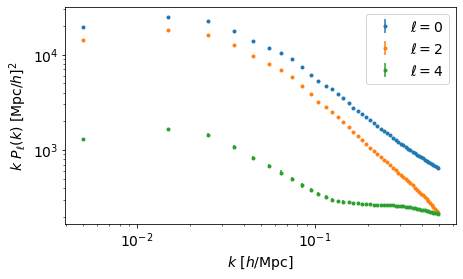

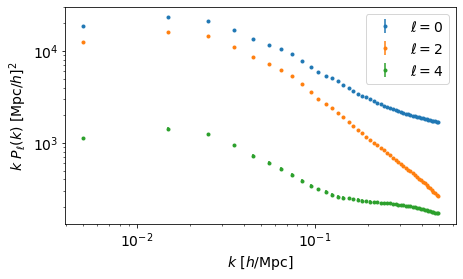

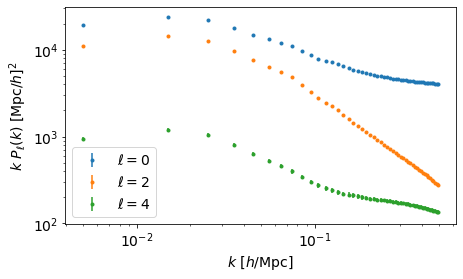

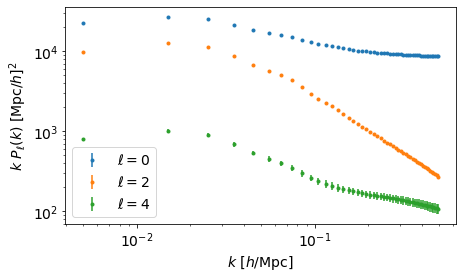

In [83]:
plt.figure(figsize=(7,4))
for i in range(3): 
    plt.errorbar(kd, bPk1[i], yerr=kd*err1[i], fmt='.', label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
plt.figure(figsize=(7,4))
for i in range(3): 
    plt.errorbar(kd, bPk2[i], yerr=kd*err2[i], fmt='.', label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
plt.figure(figsize=(7,4))
for i in range(3): 
    plt.errorbar(kd, bPk3[i], yerr=kd*err3[i], fmt='.', label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
plt.figure(figsize=(7,4))
for i in range(3): 
    plt.errorbar(kd, bPk4[i], yerr=kd*err4[i], fmt='.', label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

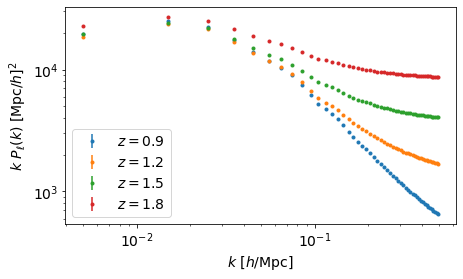

In [84]:
plt.figure(figsize=(7,4))
plt.errorbar(kd, bPk1[0], yerr=kd*err1[0], fmt='.', label=r'$z=%s$' % z[0])
plt.errorbar(kd, bPk2[0], yerr=kd*err2[0], fmt='.', label=r'$z=%s$' % z[1])
plt.errorbar(kd, bPk3[0], yerr=kd*err3[0], fmt='.', label=r'$z=%s$' % z[2])
plt.errorbar(kd, bPk4[0], yerr=kd*err4[0], fmt='.', label=r'$z=%s$' % z[3])
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

### Creating the fake data

We are now ready to create our fake data. For that, we can use the build-in function in the `ReadWrite` class. 

In [85]:
io = ReadWrite()

The data structure is a dictionary. 

In [86]:
d = {}

Each sky corresponds to an entry in this dictionary, which is itself a dictionary containing the data. 

Here we have four skyes, and we name it 'sky_1', 'sky_2', 'sky_3', 'sky_4'. 

In [87]:
d['sky_1'] = {}
d['sky_2'] = {}
d['sky_3'] = {}
d['sky_4'] = {}

We now start filling this dictionary with the data. 

In [93]:
zmin = np.array([0.85, 1.05, 1.35, 1.65])
zmax = np.array([1.05, 1.35, 1.65, 1.95])
H_fid = np.array([H_fid1, H_fid2, H_fid3, H_fid4])
D_fid = np.array([D_fid1, D_fid2, D_fid3, D_fid4])

In [95]:
for i, zi in enumerate(z):
    io.write_common(d['sky_'+str(i+1)], zmin[i], zmax[i], zi, Omega_m_fid, H_fid[i], D_fid[i])

print (d['sky_1']['z'].keys())
print (d['sky_1']['fid'].keys())

dict_keys(['min', 'max', 'eff'])
dict_keys(['Omega_m', 'H', 'D'])


In [98]:
bpk = np.array([bPk1, bPk2, bPk3, bPk4])
cov = np.array([cov1, cov2, cov3, cov4])

In [ ]:
mult_pk = 3
for i, zi in enumerate(z):
    io.write_pk(d['sky_'+str(i+1)], mult_pk, kd, bpk[i], cov[i], nsims_cov_pk=0, 
            survey_mask_arr_p=None, survey_mask_mat_kp=None,
            binsize=dk)

In [100]:
print (d['sky_1']['bPk'].keys())

dict_keys(['multipole', 'x', 'cov', 'nsims', 'survey_mask', 'binsize', 'l0', 'l2', 'l4'])


Here we are not providing a survey mask. One can compute the survey mask from random catalogs using https://github.com/pierrexyz/fkpwin , in a format compatible with PyBird: 
```
survey_mask = np.load('output_fkpwin/Wlmkp_skyname.npz')
survey_mask_arr_p = survey_mask['p']
survey_mask_mat_kp = survey_mask['Wlm']
```
Also, there are two other build-in functions that we are not using here, feel free to explore!
    
```
io.write_cf(d_sky, mult_cf, ss, cf, cov_cf, nsims_cov_cf=0, binsize=None)
io.write_bao_rec(d_sky, bao_rec_rd_fid, bao_rec_H_fid, bao_rec_D_fid, alpha_par, alpha_per, 
                 cov_alpha, cov_cross_pk=None, cov_cross_cf=None)
```



Finally we save our fake data. 

In [101]:
np.save(os.path.join(datadir, 'fake_Euclid', 'fake_Euclid.npy'), d)

### Testing the fake data

Cool. Now let us test the fake data by maximazing the likelihood: do we recover the truth?

We first need a configuration file. Let us create one. 

In [24]:
configdir = os.path.join(datadir, 'eftboss', 'config')

For simplicity, let us load a configuration file and modify it accordingly. 

In [25]:
config = yaml.full_load(open(os.path.join(configdir, 'boss_cmass_ngc_pk_wc.yaml'), 'r'))
config["data_path"] = os.path.join(datadir, 'fake')
config["data_file"] = 'fake_example_2pt.npy'
config["multipole"] = 3
config["with_survey_mask"] = False
config["with_binning"] = True

config["sky"]['sky_1'] = config["sky"].pop('cmass_ngc')
config["sky"]['sky_1']['min'] = [0.01, 0.01, 0.01]
config["sky"]['sky_1']['max'] = [0.20, 0.20, 0.20]

config["write"]["fake"] = True
config["write"]["out_path"] = os.path.join(datadir, 'fake', 'out')
config["write"]["out_name"] = 'sky_1'

We center the prior on the truth for this check. 

In [26]:
for name, truth in eft_truth.items(): 
    if name not in ['b1', 'b2', 'b4', 'c4']: 
        config["eft_prior"][name]['mean'] = [truth]

In [27]:
print ( yaml.dump(config, indent=4, sort_keys=False))

data_path: /Users/pierre/Documents/github/pybird/data/fake
data_file: fake_example_2pt.npy
output: bPk
multipole: 3
with_ap: true
with_survey_mask: false
sky:
    sky_1:
        min:
        - 0.01
        - 0.01
        - 0.01
        max:
        - 0.2
        - 0.2
        - 0.2
write:
    save: true
    fake: true
    plot: true
    show: true
    out_path: /Users/pierre/Documents/github/pybird/data/fake/out
    out_name: sky_1
km: 0.7
kr: 0.35
nd: 0.0004
eft_basis: westcoast
with_stoch: true
eft_prior:
    b1:
        type: flat
        range: null
    c2:
        type: gauss
        mean:
        - 0.5863
        range:
        - 2.0
    c4:
        type: unvaried
    b3:
        type: marg_gauss
        mean:
        - -0.3948
        range:
        - 2.0
    cct:
        type: marg_gauss
        mean:
        - 0.1839
        range:
        - 2.0
    cr1:
        type: marg_gauss
        mean:
        - -0.8414
        range:
        - 2.0
    cr2:
        type: marg_gauss
    

Let us setup the likelihood with this configuration. 

In [28]:
L = Likelihood(config)

reading data file: /Users/pierre/Documents/github/pybird/data/fake/fake_example_2pt.npy
-----------------------
sky: sky_1
output: bPk
multipole: 3
min bound (per multipole): [0.01, 0.01, 0.01]
max bound (per multipole): [0.2, 0.2, 0.2]
coordinate (AP) distortion: on
binning: on
-----------------------
-----------------------
get_maxlkl : False
with_boss_correlated_skies_prior : False
with_rs_marg : False
-----------------------


We initialize the likelihood. 

In [29]:
eft_name = ['b1', 'c2'] 
eft_init = [2, 0.] 
init = L.loglkl(eft_init, eft_name, M, need_cosmo_update=True)

We can now maximize the likelihood. 

In [30]:
L.c["get_maxlkl"] = True # minimization mode

def chi2(eft_params): return -2. * L.loglkl(eft_params, eft_name, M, need_cosmo_update=False)
minimum = minuit(chi2, eft_init)

from scipy import stats
def pvalue(minchi2, dof): return 1. - stats.chi2.cdf(minchi2, dof)
dof = L.y_all.shape[0] - len(eft_name) - L.Ng # number of data points - EFT parameters
print ('min chi2: %.2f, p-value: %.3f' % (minimum['fun'], pvalue(minimum['fun'], dof)))

min chi2: 0.00, p-value: 1.000


Looks like we have recovered the truth ($\chi^2 = 0$)! Let us see how well we have recovered it: 

In [31]:
print ('- ratio fit/truth -')
for name, truth, fit in zip(eft_truth.keys(), eft_truth.values(), L.out[0]['eft_parameters'].values()):
    if name not in ['b2', 'b4', 'c4', 'ce1']: # those are not in the westcoast prior
        print ('%s: %.2f' % (name, fit/truth))

- ratio fit/truth -
b1: 1.00
c2: 1.00
b3: 1.00
cct: 1.00
cr1: 1.01
cr2: 0.99
ce0: 1.00
ce2: 1.00


### Build-in fake data generator from best fit

By the way, did you know that there is a build-in function that can create fake data directly from a fit?

This happens if we set: ```config["write"]["fake"] = True``` and run the following function: 

fake data from best fit saved to /Users/pierre/Documents/github/pybird/data/fake.
data files with best fit saved to /Users/pierre/Documents/github/pybird/data/fake/out.
data plot with best fit saved to /Users/pierre/Documents/github/pybird/data/fake/out.


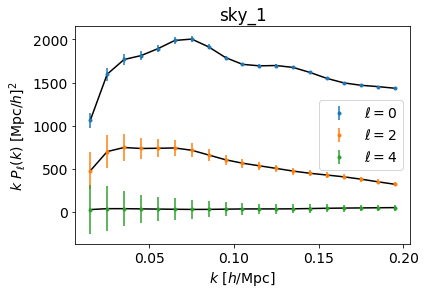

In [32]:
L.write()

Let us see if this is real! This is the automatically generated file from the previous minimization:

In [33]:
config["data_file"] = 'fake_sky_1.npy'

Let us try it.

In [34]:
L = Likelihood(config)

reading data file: /Users/pierre/Documents/github/pybird/data/fake/fake_sky_1.npy
-----------------------
sky: sky_1
output: bPk
multipole: 3
min bound (per multipole): [0.01, 0.01, 0.01]
max bound (per multipole): [0.2, 0.2, 0.2]
coordinate (AP) distortion: on
binning: on
-----------------------
-----------------------
get_maxlkl : True
with_boss_correlated_skies_prior : False
with_rs_marg : False
-----------------------


In [35]:
init = L.loglkl(eft_init, eft_name, M, need_cosmo_update=True)

In [36]:
L.c["get_maxlkl"] = True # minimization mode

def chi2(eft_params): return -2. * L.loglkl(eft_params, eft_name, M, need_cosmo_update=False)
minimum = minuit(chi2, eft_init)

from scipy import stats
def pvalue(minchi2, dof): return 1. - stats.chi2.cdf(minchi2, dof)
dof = L.y_all.shape[0] - len(eft_name) - L.Ng # number of data points - EFT parameters
print ('min chi2: %.2f, p-value: %.3f' % (minimum['fun'], pvalue(minimum['fun'], dof)))

min chi2: 0.00, p-value: 1.000


Cool.